# Projet 5: Segmentez des clients d'un site e-commerce

## notebook de simulation

Dans cette partie, l'objectif est de déterminer la fréquence nécessaire de mise à jour du modèle de segmentation, afin que celui-ci reste pertinent.
-	Pour prendre un exemple, supposons que l’entraînement du modèle initial M0 ait été réalisé à T0 pour un fichier clients F0, qui donne la liste des numéros de clusters C0, CO=M0.fit(F0).
-	À T1=T0 +n jours, un nouveau modèle M1 est entraîné sur le nouveau fichier clients F1 à T1, et donne une nouvelle liste de clusters C1, C1_new = M1.fit(F1).
-	Si on utilise le modèle initial M0, à T1 la prédiction des numéros de clusters du fichier F1 des clients à T1 donne C1_init = M0.predict(F1).
-	Il s’agit de comparer les numéros de clusters à T1 du fichier F1, selon que l’on utilise le modèle initial créé à T0(M0) via un « predict », ou le modèle créé à T1 via un « fit ».

Il est possible d’évaluer la cohérence entre les clusters de départ et le partitionnement trouvé par K-means en utilisant l’indice Ajusted_Rand_Score


Nous commencerons notre simulation avec les données existantes à t=12 mois ,nous recommencerons les simulations en ajoutant 1 mois supplementaire, et ainsi de suite. Nous comparerons les numéros de clusters à T1 du fichier F1, selon que l’on utilise le modèle initial créé à T0(M0) via un « predict », ou le modèle créé à T1 via un « fit ».



#### Importation des données 

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from math import pi
from sklearn.cluster import KMeans , AgglomerativeClustering, DBSCAN

from sklearn.metrics.cluster import adjusted_rand_score

from datetime import datetime
import matplotlib.dates as mdates

Dans cette partie, nous allons utiliser le fichier commande créé dans le notebook 1 (exploration de données). il s'agira dans une premier temps de créer un fichier comprenant les commandes sélectionnées en fonction d'une période donnée.

In [2]:
#chargement de la table
df_clients = pd.read_csv('data_clients.csv')
df_clients.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,region,order_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,...,moyen_paiement_prefere,echeances,frais_de_port,delivery_delay,review_mean_score,product_volume_cm3,dernier_achat,rfm_recence,rfm_frequence,rfm_montant
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409.0,franca,sud_est,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,...,credit_card,2.0,21.88,8 days 19:30:00,4.0,107136.0,2017-05-16 15:05:35,470.0,1.0,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790.0,sao bernardo do campo,sud_est,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,...,credit_card,8.0,46.48,16 days 15:52:55,5.0,53400.0,2018-01-12 20:48:24,229.0,1.0,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151.0,sao paulo,sud_est,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,...,credit_card,7.0,17.79,26 days 01:51:06,5.0,45968.0,2018-05-19 16:07:45,102.0,1.0,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775.0,mogi das cruzes,sud_est,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,...,credit_card,1.0,23.36,14 days 23:57:47,5.0,79968.0,2018-03-13 16:06:38,169.0,1.0,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056.0,campinas,sud_est,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,...,credit_card,8.0,22.25,11 days 11:04:18,5.0,23625.0,2018-07-29 09:51:30,32.0,1.0,252.25


In [3]:
# Conversion en type datetime
var_to_datetime=['order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
'shipping_limit_date',
    'dernier_achat' ]
for var in var_to_datetime:
    df_clients[var] = pd.to_datetime(df_clients[var], format='%Y-%m-%d %H:%M:%S')

In [5]:
# Période de commande
order_min = df_clients['order_purchase_timestamp'].min().strftime('%d/%m/%Y %Hh%m')
order_max = df_clients['order_purchase_timestamp'].max().strftime('%d/%m/%Y %Hh%m')
print(f'Période d\'achat : du {order_min} au {order_max}')

Période d'achat : du 03/10/2016 09h10 au 29/08/2018 15h08


In [6]:
#La periode de commande en mois 
orders_months = round((df_clients['order_purchase_timestamp'].max() - df_clients['order_purchase_timestamp'].min())/ np.timedelta64(1,'M'))

print("La période d'achat est de",orders_months,"mois")

La période d'achat est de 23 mois


In [7]:
'''Fonction qui sélectionne les commandes en fonction de la période 
définie.
On recalculera les différentes variables utilisées dans la simulation.
'''
def selection_period(df, initial=False, period=1):
    #Fonction qui génère un fichier en fonction de la date 
      
    # selection en fonction de la date de commande
    #order Month
    df["sale_month"] = df['order_purchase_timestamp'].dt.month
    start=df['order_purchase_timestamp'].min()
    if(initial == True):
        period = 12
    else:
        period = 12+period
    stop=start + pd.DateOffset(months=period)
        
    df=df[(df['order_purchase_timestamp']>=start)
                              & (df['order_purchase_timestamp']<stop)]
    
    # List of orders on period
    period_orders = df.order_id.unique()
    
    # Calculate other features on period
    df = df[df['order_id'].isin(period_orders)]
    #creation du dataset clients 
    
    dico_aggr = {
             'rfm_recence': 'mean',
             'rfm_frequence': 'mean',
             'rfm_montant': 'mean',
             'review_mean_score':'mean',
             'nombre_produits': 'mean',
             'echeances': 'mean',
             }
    df_new=df.groupby(['customer_unique_id']).agg(dico_aggr)
    
    return df_new

In [8]:
#transformation en log 
def transformation_log(df, var):
    for i in var:
         df[i] = np.log1p(df[i])
    return df

In [9]:
def scaler(df):
    cols=df.columns
    scaler=StandardScaler()
    df=scaler.fit_transform(df)
    df=pd.DataFrame(df,columns=[cols])
    return df

In [10]:
#fonction de calcul de l'ARI
def fonction_maintenance (df, k):
    
    df_initial=selection_period(df,initial=True, period=1)
    #au temps T0
    #var=df_initial.columns.to_list()
    #var.remove('rfm_recence')
    #df_initial=transformation_log(df_initial, var)
    X_0=scaler(df_initial).values
    
    model_initial=KMeans(n_clusters=k)
    model_initial.fit(X_0)
    model_initial_labels=model_initial.labels_
    
    
    #simulaition Ti, Ti+1
    ari_score = []
    for i in range(1,int((orders_months-12))):
        df_heredite=selection_period(df,initial=False, period=i)
        #df_heredite=transformation_log(df_heredite, var)
        
        X=scaler(df_heredite).values
        model_h=KMeans(n_clusters=k)
        model_h.fit(X)
        model_h_labels=model_h.labels_
       
        ari_i = adjusted_rand_score(model_initial.predict(X),model_h_labels)
        ari_score.append([i,ari_i])
        
    return ari_score

In [15]:
ari_score=fonction_maintenance (df_clients, 6)

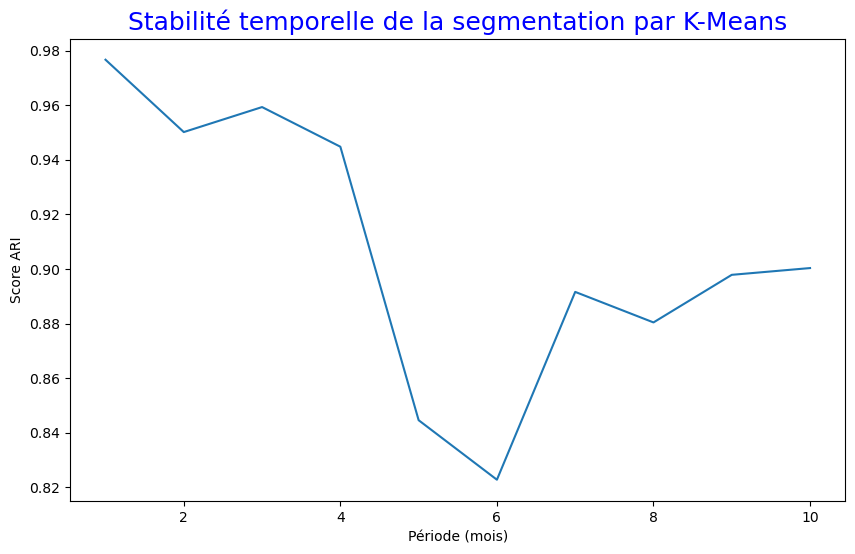

In [16]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(10,6))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.xlabel("Période (mois)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

Sur ce plot des scores ARI obtenus, on remarque une forte inflexion après 4 mois sur les clients initiaux.

Il faudra donc prévoir la maintenance du programme de segmentation tous les 4 mois dans un premier temps puis re-tester cette stabilité temporelle au fil du temps afin de l'affiner.